In [ ]:
!pip install segmentation_models_pytorch

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import albumentations as A
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation

In [ ]:
!unzip jpeg_images.zip
!unzip jpeg_masks.zip

In [3]:
img_dir, msk_dir = '/content/IMAGES', '/content/MASKS'
print(len(os.listdir(img_dir)))
print(len(os.listdir(msk_dir)))

1000
1000


In [4]:
img_fls = [os.path.join(img_dir, f'img_{id:04}.jpeg') for id in range(1,1001)]

train_img_paths, val_img_paths = train_test_split(img_fls, test_size=0.25, random_state=0)

In [5]:
train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [30]:
class SegmDataset(Dataset):
    def __init__(self, img_paths, mask_dir, transform=None):
        self.img_paths = img_paths
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        msk_name = img_path.split('/')[-1].replace('img','seg')
        mask_path = os.path.join(self.mask_dir, msk_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [31]:
max_msk = 59
for img_path in tqdm(train_img_paths):
  # img_path = train_img_paths[2]
  msk_name = img_path.split('/')[-1].replace('img','seg')
  mask_path = os.path.join(msk_dir, msk_name)

  image = np.array(Image.open(img_path).convert("RGB"))
  mask = np.array(Image.open(mask_path))

  last_msk = np.unique(mask)[-1]
  if last_msk > max_msk:
    max_msk = last_msk
  
print(max_msk)

  0%|          | 0/750 [00:00<?, ?it/s]

65


In [32]:
img_path = train_img_paths[0]
msk_name = img_path.split('/')[-1].replace('img','seg')
mask_path = os.path.join(msk_dir, msk_name)

image = np.array(Image.open(img_path).convert("RGB"), dtype=np.int64)
mask = np.array(Image.open(mask_path).convert("L"))

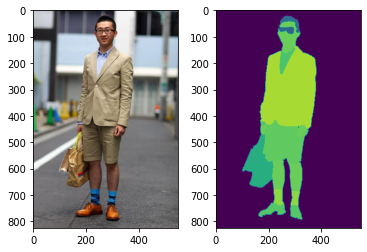

In [33]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(image)
axs[1].imshow(mask)

In [34]:
train_dataset = SegmDataset(train_img_paths, msk_dir, train_transform)
val_dataset = SegmDataset(val_img_paths, msk_dir, val_transforms)

In [35]:
train_loader = DataLoader( train_dataset, batch_size=16, shuffle=True )

valid_loader = DataLoader( val_dataset, batch_size=16, shuffle=True )

dataloaders = {'train':train_loader, 'val':valid_loader}

In [36]:
model = smp.Unet('resnet18', in_channels=3, classes=66)
model = model.to(device)

In [37]:
#Optmizer and loss function
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

In [38]:
def train_model(model,criterion,optimizer,dataloaders,epochs,check_every=None,earlyStopping=False):

  print("training model")
  optimizer.zero_grad()

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  phases = dataloaders.keys()
  valExists = True if "val" in phases else False
  avg_loss = {phase:0 for phase in phases}
  avg_losses = {phase:[] for phase in phases}

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    batchLoss = {phase:[] for phase in phases}

     # Each epoch has a training and validation phase
    for phase in phases:
      if phase == "train":  model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode
        
      for i, (inputBatch,labelBatch) in enumerate(tqdm(dataloaders[phase], leave=False)):

          inputBatch = inputBatch.to(device)
          labelBatch = labelBatch.type(torch.LongTensor).to(device)
          
          # forward
          with torch.set_grad_enabled(not phase=="val"):
            outputBatch = model(inputBatch)

          loss = criterion(outputBatch, labelBatch)
          batchLoss[phase].append(loss.item())

          # backward + optimize only if in training phase
          if phase == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


    for phase in phases : avg_loss[phase] = np.mean(batchLoss[phase])
        
    phase = "val" if valExists else "train"
    if epoch > 0:
      if avg_loss[phase] < min(avg_losses[phase]):
        best_params = deepcopy(model.state_dict())
        best_epoch, best_loss = epoch, avg_loss[phase]
    else:
      best_params = deepcopy(model.state_dict())
      best_epoch, best_loss = epoch, avg_loss[phase]
      movAvg_old = avg_loss[phase]

    for phase in phases : avg_losses[phase].append(avg_loss[phase])  

    # print statistics
    if epoch % check_every == check_every - 1:
      print("epoch: %d" % (epoch + 1), end="  | ")
      for phase in phases:
        print("%s loss: %.3f" % (phase, avg_loss[phase]), end=", ")
      if check_every > 1:
        print(" | ", end='')
        for phase in phases:        
          print("avg %s loss: %.3f" % (phase, np.mean(avg_losses[phase][epoch+1-check_every:epoch+1])), end=", ")
      if valExists:
        movAvg_new = np.mean(avg_losses["val"][epoch+1-check_every:epoch+1])

      if (valExists) and earlyStopping:
        if movAvg_old < movAvg_new:   break
        else:   movAvg_old = movAvg_new



  end_params = deepcopy(model.state_dict())
  print('Finished Training')
  for phase in phases:  plt.plot(avg_losses[phase], label=phase+" loss")
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params, end_params

training model


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 1  | train loss: 2.331, val loss: 0.960, 

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 2  | train loss: 0.855, val loss: 0.807, 

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 3  | train loss: 0.772, val loss: 0.775, 

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 4  | train loss: 0.749, val loss: 0.723, 

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 5  | train loss: 0.695, val loss: 0.675, Finished Training


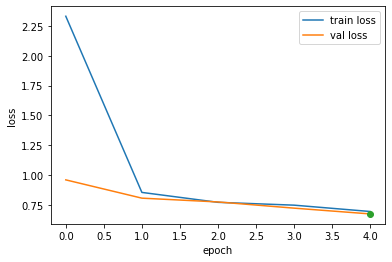

In [39]:
best_params, end_params = train_model(model, criterion, optimizer, dataloaders, 5)

In [16]:
#model(best_params)

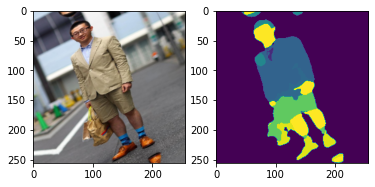

In [46]:
img, msk = train_dataset[0]

fig, axs = plt.subplots(1,2)
axs[0].imshow(img.swapaxes(0,2).swapaxes(0,1))

img = img.unsqueeze(0).to(device)
pred = model(img).squeeze()
pred = pred.argmax(0).cpu().detach().numpy()

axs[1].imshow(pred)

(array([ 0,  2,  5, 13, 14, 19, 31, 39, 41]), array([50654,    80,   298,  5776,  1056,   457,  3101,  1158,  2956]))


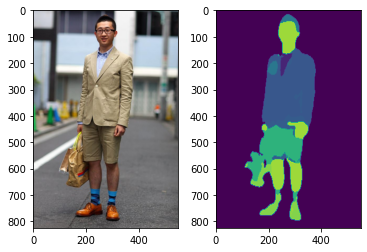

In [40]:
fig, axs = plt.subplots(1,2)
img_path = train_img_paths[0]

img = Image.open(img_path).convert("RGB")
original_size = img.size
axs[0].imshow(img)
img = img.resize((256,256))

img = np.array(img, dtype=np.int64)
img = np.swapaxes(img, 0,2)
img = np.swapaxes(img, 1,2)
img = torch.from_numpy(img).to(device)
img = img.unsqueeze(0)/255

pred = model(img).squeeze()
pred = pred.argmax(0).cpu().detach().numpy()
print(np.unique(pred, return_counts=True))
pred = Image.fromarray(pred.astype(np.uint8))
pred = pred.resize(original_size)
pred = np.array(pred, dtype=np.int64)

axs[1].imshow(pred)